PLAN

* One example of analytical system to generate a discrete spatial and temporal vector field, with grids in space and time

* Then we interpolate

_Energy_ 

\begin{equation*}
H(x, p_x, t) = \frac{1}{2} (p_x^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_ whith _time-dependent harmonic forcing_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} + + \eta(t) = f_2(x, p_x) = x - x^3 + \eta(t)
 \end{align*}
 
where

\begin{align*}
\eta(t) = A \cdot sin(\omega t)
\end{align*}

with $A$ and $\omega$ the amplitude and the frequency of the perturbation.

* Provide files with fine discretisation and rough.

In [1]:
import pylds
import numpy as np
import matplotlib.pylab as plt
from pylds.base import compute_lagrangian_descriptor, perturb_field, fit_pes
from pylds.tools import draw_all_lds
from pylds.vector_fields import Duffing1D, Duffing1D_inverted, forcing

SLICE PARAMETERS

In [16]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [17]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field_original = Duffing1D

perturbation_type, amplitude, freq = [1, 1, 1]
perturbation_params = [perturbation_type, amplitude, freq]

perturbation = lambda t, u: forcing(t, u, perturbation_params=perturbation_params)
vector_field = perturb_field(vector_field_original, perturbation)

Define grid for sampling of data-points

* We require the spatial domain of the vector field to be larger than the domain where the LD is computed - otherwise this can lead to boarder effects on the interpolation

SLICE FOR INTERPOLATION

In [56]:
x_min,x_max = [-2, 2]
y_min,y_max = [-1.5, 1.5]
t_min, t_max = [0, 10]

Nx, Ny, Nt = [21, 15, 11]

x = np.linspace(x_min,x_max,Nx)
y = np.linspace(y_min,y_max,Ny)

X, Y = np.meshgrid(x, y)

In [38]:
points = np.column_stack([X.ravel(), Y.ravel()])

In [39]:
vector_field_frames = [vector_field(t, points) for t in np.linspace(t_min,t_max,Nt)]
vector_field_frames = np.array(vector_field_frames)

VECTOR FIELD  from analytical expression

TypeError: Length of x (21) must match number of columns in z (15)

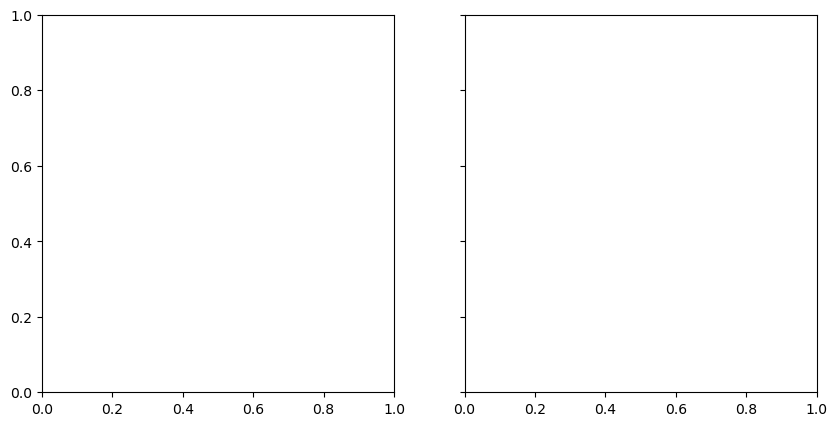

In [40]:
fig,ax = plt.subplots(1,2,figsize=(10,5) ,dpi=100, sharex=True, sharey=True)

C = np.linalg.norm(vector_field_frames[0],axis=1)
u, v = vector_field_frames[0].T
ax[0].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[0].quiver(points.T[0], points.T[1], u, v, zorder=100)

C = np.linalg.norm(vector_field_frames[10],axis=1)
u, v = vector_field_frames[10].T
ax[1].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[1].quiver(points.T[0], points.T[1], u, v, zorder=100)

plt.show()

VECTOR FIELD  from interpolating vector field data

In [41]:
from scipy import interpolate

t = np.linspace(t_min, t_max, Nt)
vector_field_interp = interpolate.interp1d(t, vector_field_frames.T, kind='cubic')

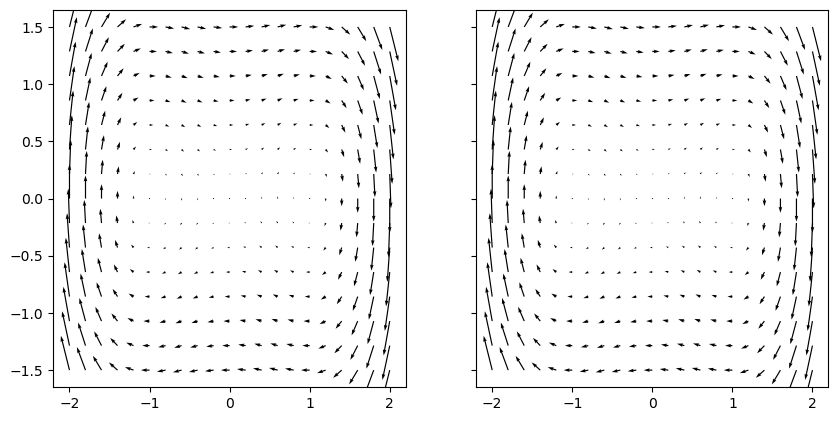

In [42]:
fig,ax = plt.subplots(1,2,figsize=(10,5) ,dpi=100, sharex=True, sharey=True)

t0 = 0

# from analytical expression
x, y = points.T
u, v = vector_field(t0, points).T
ax[0].quiver(x, y, u, v)


# from evaluating interpolated function
x, y = points.T
u, v = vector_field_interp(t0)
ax[1].quiver(x, y, u, v)

plt.show()

SANITY TEST about precision

In [43]:
for t0 in np.linspace(t_min, t_max, 6):
    test = (vector_field(t0, points).T == vector_field_interp(t0)).all()
    diff = vector_field(t0, points).T - vector_field_interp(t0)
    print(t0, test, diff.min(), diff.max())

0.0 True 0.0 0.0
2.0 False -8.881784197001252e-16 8.881784197001252e-16
4.0 False -8.881784197001252e-16 4.440892098500626e-16
6.0 False -8.881784197001252e-16 2.220446049250313e-16
8.0 False -4.440892098500626e-16 8.881784197001252e-16
10.0 True 0.0 0.0


In [44]:
t0 = 0
p = vector_field_interp(t0)

In [45]:
p.shape

(2, 315)

In [51]:
p[1].shape

(315,)

SPATIAL INTERPOLATION

Grid for LD slice

In [53]:
# Mesh parameters
xp_min,xp_max = [-1.9, 1.9]
yp_min,yp_max = [-1.4, 1.4]
Nxp, Nyp = [101, 121]

In [54]:
xp = np.linspace(xp_min,xp_max, Nxp)
yp = np.linspace(yp_min,yp_max, Nyp)

`x` and `y` form sampling grid

In [61]:
f0 = interpolate.interp2d(x, y, p[0], kind='cubic')
f1 = interpolate.interp2d(x, y, p[1], kind='cubic')

In [63]:
up = f0(xp,yp).shape

(121, 101)

In [65]:
vp = f1(xp,yp).shape

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

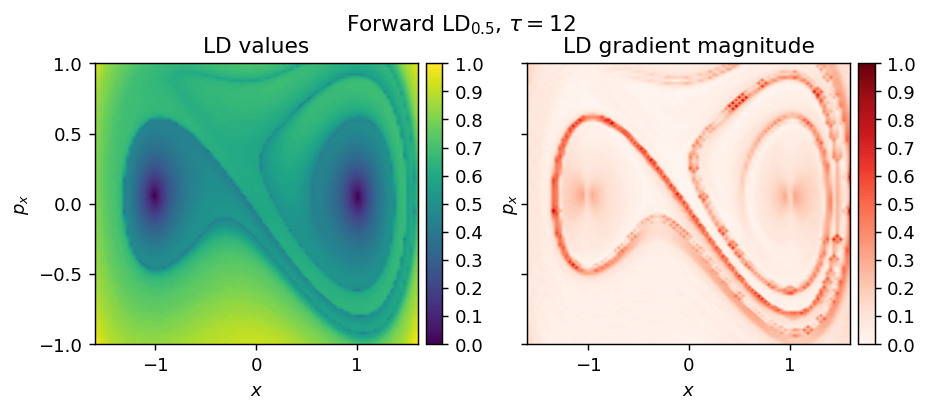

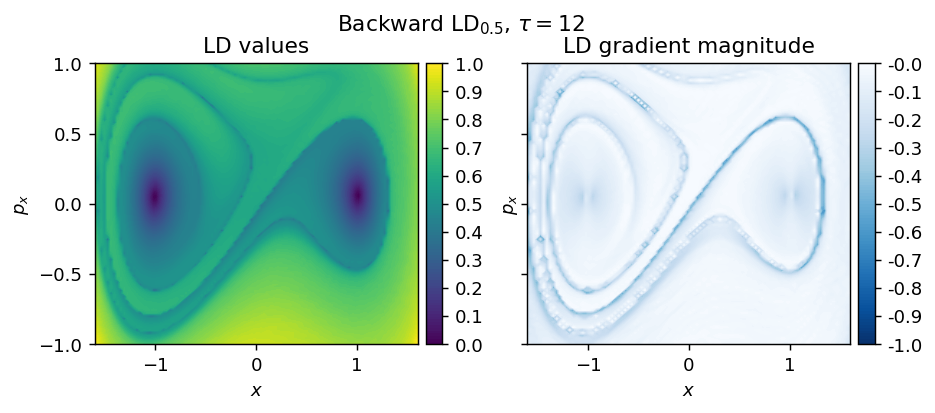

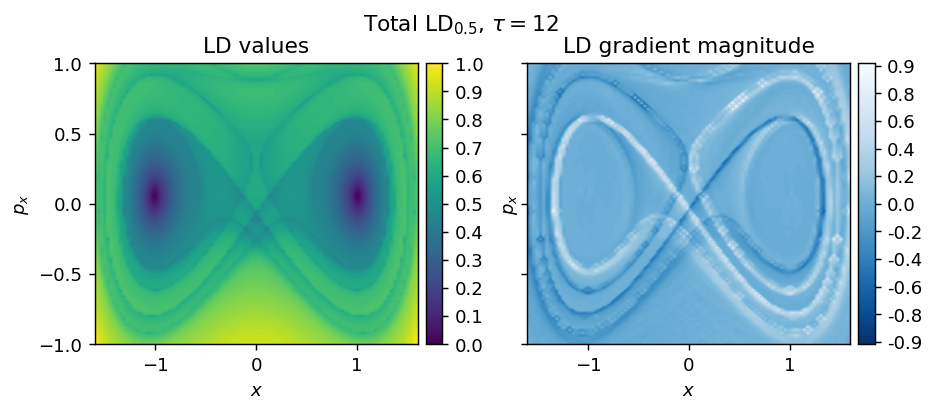

In [4]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

figs = draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value, interactive=False)